# Multimodal Stance Classification with Image Captions

This notebook explores the impact of adding image captions to the multimodal model.

Configurations to Evaluate (33 models):

**1. Text Only (1 model)**

- Baseline: Only DeBERTa processing original text

**2. Text + Caption (2 models)**

- DeBERTa processing: `text + [SEP] + caption`. 
- No image. 
- 2 Types of Caption: caption_blip2, caption_git

**3. Text + Image (10 models)**

- DeBERTa (text) + Vision encoder (image). 
- Without caption. 
- 2 vision encoders


**4. Text + Caption + Image (20 models)**
- DeBERTa (text + caption) + Vision encoder (image)
- Variants: 2 caption types × 2 vision encoders × 5 fusion strategies

**Metric Goal** Binary F1-Score (pos_label=1)

In [1]:
# Libraries
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import warnings
from transformers import AutoTokenizer,AutoModel,BlipProcessor,BlipModel,AlignProcessor,AlignModel,get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings('ignore')

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device: NVIDIA H100 NVL


In [2]:
# Paths
DATA_PATH = "../../../data/"
IMG_PATH = "../../../data/images"
OUTPUT_DIR = "../../../results/multimodal/caption_experiments/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# Model Names
TEXT_MODEL_NAME = "microsoft/deberta-v3-base"  # 768 dims
BLIP_MODEL_NAME = "Salesforce/blip-itm-base-coco"  # 768 dims
ALIGN_MODEL_NAME = "kakaobrain/align-base"

# Text processing
MAX_TEXT_LENGTH = 128

# Common embedding dimension
COMMON_DIM = 768

print(f"Text Model: {TEXT_MODEL_NAME}")
print(f"BLIP Model: {BLIP_MODEL_NAME}")
print(f"ALIGN Model: {ALIGN_MODEL_NAME}")
print(f"Common dimension: {COMMON_DIM}")

Text Model: microsoft/deberta-v3-base
BLIP Model: Salesforce/blip-itm-base-coco
ALIGN Model: kakaobrain/align-base
Common dimension: 768


In [4]:
# Training hyperparameters
BATCH_SIZE = 16
NUM_EPOCHS = 15
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-4
WARMUP_RATIO = 0.1
PATIENCE = 5

# Number of classes
NUM_CLASSES = 2  # (Oppose, Support)

print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Patience: {PATIENCE}")
print(f"Num classes: {NUM_CLASSES}")

Batch size: 16
Epochs: 15
Learning rate: 2e-05
Patience: 5
Num classes: 2


In [5]:
# Load datasets with captions
df_train = pd.read_csv(os.path.join(DATA_PATH, "train_with_captions.csv"))
df_dev = pd.read_csv(os.path.join(DATA_PATH, "dev_with_captions.csv"))
df_test = pd.read_csv(os.path.join(DATA_PATH, "test_with_captions.csv"))

# Map labels to ints
stance_2id = {"oppose": 0, "support": 1}
pers_2id = {"no": 0, "yes": 1}

for df in [df_train, df_dev, df_test]:
    df["label"] = df["stance"].map(stance_2id)
    df["persuasiveness_label"] = df["persuasiveness"].map(pers_2id)


print(f"\n Train label distribution:")
print(f"\n Stance: \n Oppose: {(df_train['label']==0).sum()}\n Support: {(df_train['label']==1).sum()}")
print(f"\n\n  Persuasiveness \n No: {(df_train['persuasiveness_label']==0).sum()}\n Yes: {(df_train['persuasiveness_label']==1).sum()}")


df_train.head()


 Train label distribution:

 Stance: 
 Oppose: 1095
 Support: 1095


  Persuasiveness 
 No: 1548
 Yes: 642


,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,label,persuasiveness_label,caption_blip2,caption_git
0,1148501065308004357,https://t.co/VQP1FHaWAg,Let's McGyver some Sanity in America!\n\nYou a...,support,no,train,1,0,remember that time i couldn't myself out of tr...,"[ unused0 ], [ unused0 ], [ unused0 ], [ unuse..."
1,1103872992537276417,https://t.co/zsyXYSeBkp,A child deserves a chance at life. A child des...,oppose,no,train,0,0,i deserve to be loved,i deserve to be like this.
2,1151528583623585794_aug,https://t.co/qSWvDX5MnM,"Dear prolifers: girls as young as 10, 11, 12 a...",support,no,train,1,0,the text of the email is displayed in the imag...,a close up of a text on a white background
3,1100166844026109953,https://t.co/hxH8tFIHUu,The many States will attempt to amend their co...,support,no,train,1,0,keep abortion legal and safe,a red circle with the words ` ` keep abortion ...
4,1021830413550067713,https://t.co/5whvEEtoQR,"Every #abortion is wrong, no matter what metho...",oppose,yes,train,0,1,"a pregnant woman's body with the words, your b...",your body? since when does a female body have ...


In [6]:
class TextOnlyDataset(Dataset):
    """
    Dataset for text-only baseline.
    """
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row['tweet_text'])
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(row['label'], dtype=torch.long)
        }

In [7]:
class TextCaptionDataset(Dataset):
    """
    Dataset for text + caption (no image).
    """
    def __init__(self, df, tokenizer, caption_column, max_length=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.caption_column = caption_column
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Concatenate text + [SEP] + caption
        text = str(row['tweet_text'])
        caption = str(row[self.caption_column])
        combined_text = f"{text} [SEP] {caption}"
        
        encoding = self.tokenizer(
            combined_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(row['label'], dtype=torch.long)
        }

In [8]:
class MultimodalDataset(Dataset):
    """
    Dataset for text + image (no caption in text).
    """
    def __init__(self, df, img_dir, tokenizer, image_processor, max_length=128):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Text
        text = str(row['tweet_text'])
        text_encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Image
        img_path = os.path.join(self.img_dir, str(row['tweet_id']) + ".jpg")
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            image = Image.new("RGB", (224, 224), color=(128, 128, 128))
        
        image_encoding = self.image_processor(images=image, return_tensors='pt')
        
        return {
            'input_ids': text_encoding['input_ids'].squeeze(0),
            'attention_mask': text_encoding['attention_mask'].squeeze(0),
            'pixel_values': image_encoding['pixel_values'].squeeze(0),
            'label': torch.tensor(row['label'], dtype=torch.long)
        }

In [9]:
class MultimodalCaptionDataset(Dataset):
    """
    Dataset for text + caption + image (full multimodal).
    """
    def __init__(self, df, img_dir, tokenizer, image_processor, caption_column, max_length=128):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.caption_column = caption_column
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Text + Caption
        text = str(row['tweet_text'])
        caption = str(row[self.caption_column])
        combined_text = f"{text} [SEP] {caption}"
        
        text_encoding = self.tokenizer(
            combined_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Image
        img_path = os.path.join(self.img_dir, str(row['tweet_id']) + ".jpg")
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            image = Image.new("RGB", (224, 224), color=(128, 128, 128))
        
        image_encoding = self.image_processor(images=image, return_tensors='pt')
        
        return {
            'input_ids': text_encoding['input_ids'].squeeze(0),
            'attention_mask': text_encoding['attention_mask'].squeeze(0),
            'pixel_values': image_encoding['pixel_values'].squeeze(0),
            'label': torch.tensor(row['label'], dtype=torch.long)
        }

In [10]:
def collate_fn_text_only(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack([item['label'] for item in batch])
    }

def collate_fn_multimodal(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'pixel_values': torch.stack([item['pixel_values'] for item in batch]),
        'labels': torch.stack([item['label'] for item in batch])
    }

## Model Classes

In [11]:
class TextOnlyModel(nn.Module):
    """
    Text-only baseline model.
    """
    def __init__(self, model_name="microsoft/deberta-v3-base", num_classes=2, dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        logits = self.classifier(pooled)
        return logits

In [12]:
class MultimodalModel(nn.Module):
    """
    Multimodal model (Text + Image) with various fusion strategies.
    """
    def __init__(
        self,
        text_model_name="microsoft/deberta-v3-base",
        vision_model_name="Salesforce/blip-itm-base-coco",
        vision_type="blip",  # "blip" or "align"
        num_classes=2,
        fusion_type="concat",
        common_dim=768,
        dropout=0.1
    ):
        super().__init__()
        
        self.fusion_type = fusion_type
        self.common_dim = common_dim
        
        # Text encoder
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_dim = self.text_encoder.config.hidden_size
        
        # Vision encoder
        if vision_type == "blip":
            blip_full = BlipModel.from_pretrained(vision_model_name)
            self.vision_encoder = blip_full.vision_model
            self.vision_dim = blip_full.config.vision_config.hidden_size
            
        else:  # align
            align_full = AlignModel.from_pretrained(vision_model_name)
            self.vision_encoder = align_full.vision_model
            self.vision_dim = align_full.config.vision_config.hidden_dim #640
        
        # Projections
        self.text_projection = nn.Linear(self.text_dim, common_dim) if self.text_dim != common_dim else nn.Identity()
        self.vision_projection = nn.Linear(self.vision_dim, common_dim) if self.vision_dim != common_dim else nn.Identity()
        
        # Fusion layers
        if fusion_type == "concat":
            self.fusion_layer = nn.Sequential(
                nn.Linear(common_dim * 2, common_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
        elif fusion_type == "mean":
            self.fusion_layer = nn.Identity()
        elif fusion_type == "weighted_mean":
            self.text_weight = nn.Parameter(torch.tensor(0.5))
            self.vision_weight = nn.Parameter(torch.tensor(0.5))
            self.fusion_layer = nn.Identity()
        elif fusion_type == "proj_concat":
            proj_dim = common_dim // 2
            self.text_proj = nn.Linear(common_dim, proj_dim)
            self.vision_proj = nn.Linear(common_dim, proj_dim)
            self.fusion_layer = nn.Sequential(
                nn.Linear(proj_dim * 2, common_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
        elif fusion_type == "gated":
            self.gate = nn.Sequential(
                nn.Linear(common_dim * 2, common_dim),
                nn.Sigmoid()
            )
            self.fusion_layer = nn.Identity()
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(common_dim, common_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(common_dim // 2, num_classes)
        )
    
    def forward(self, input_ids, attention_mask, pixel_values):
        # Text encoding
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = text_outputs.last_hidden_state[:, 0, :]
        text_emb = self.text_projection(text_emb)
        
        # Vision encoding
        vision_outputs = self.vision_encoder(pixel_values=pixel_values)
        vision_emb = vision_outputs.pooler_output
        vision_emb = self.vision_projection(vision_emb)
        
        # Fusion
        if self.fusion_type == "concat":
            fused = torch.cat([text_emb, vision_emb], dim=1)
            fused = self.fusion_layer(fused)
        elif self.fusion_type == "mean":
            fused = (text_emb + vision_emb) / 2
        elif self.fusion_type == "weighted_mean":
            w_text = torch.sigmoid(self.text_weight)
            w_vision = torch.sigmoid(self.vision_weight)
            total = w_text + w_vision
            fused = (w_text / total) * text_emb + (w_vision / total) * vision_emb
        elif self.fusion_type == "proj_concat":
            text_proj = self.text_proj(text_emb)
            vision_proj = self.vision_proj(vision_emb)
            fused = torch.cat([text_proj, vision_proj], dim=1)
            fused = self.fusion_layer(fused)
        elif self.fusion_type == "gated":
            concat = torch.cat([text_emb, vision_emb], dim=1)
            gate = self.gate(concat)
            fused = gate * text_emb + (1 - gate) * vision_emb
        
        logits = self.classifier(fused)
        return logits

### Training and Evaluation Functions

In [13]:
def train_model(
    model,
    train_loader,
    dev_loader,
    is_multimodal=False,
    num_epochs=15,
    learning_rate=2e-5,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    patience=5,
    device=DEVICE):
    
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(total_steps * warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    
    criterion = nn.CrossEntropyLoss()
    
    best_f1 = 0.0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            
            if is_multimodal:
                pixel_values = batch['pixel_values'].to(device)
                logits = model(input_ids, attention_mask, pixel_values)
            else:
                logits = model(input_ids, attention_mask)
            
            loss = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in dev_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                if is_multimodal:
                    pixel_values = batch['pixel_values'].to(device)
                    logits = model(input_ids, attention_mask, pixel_values)
                else:
                    logits = model(input_ids, attention_mask)
                
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        _, _, dev_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', pos_label=1, zero_division=0)
        
        if dev_f1 > best_f1:
            best_f1 = dev_f1
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, best_f1

In [14]:
def evaluate_model(model, test_loader, is_multimodal=False, device=DEVICE):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            if is_multimodal:
                pixel_values = batch['pixel_values'].to(device)
                logits = model(input_ids, attention_mask, pixel_values)
            else:
                logits = model(input_ids, attention_mask)
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', pos_label=1, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'f1_binary': f1,
        'precision_binary': precision,
        'recall_binary': recall}

### Initialize Tokenizers and Processors

In [15]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL_NAME)
# Image processors
blip_processor = BlipProcessor.from_pretrained(BLIP_MODEL_NAME)
align_processor = AlignProcessor.from_pretrained(ALIGN_MODEL_NAME)
print("Tokenizers and processors loaded")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Tokenizers and processors loaded


### Results Storage

In [16]:
# Store all results
all_results = []
print("Starting training of 33 models...")
print("This takes several hours.")

Starting training of 33 models...
This takes several hours.


# 1. Text Only (1 model)

In [17]:
# Create datasets
train_dataset = TextOnlyDataset(df_train, tokenizer, MAX_TEXT_LENGTH)
dev_dataset = TextOnlyDataset(df_dev, tokenizer, MAX_TEXT_LENGTH)
test_dataset = TextOnlyDataset(df_test, tokenizer, MAX_TEXT_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_text_only)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_text_only)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_text_only)

# Train model
print("Training: Text Only (DeBERTa baseline)")
model = TextOnlyModel(TEXT_MODEL_NAME, NUM_CLASSES)
trained_model, best_dev_f1 = train_model(model, train_loader, dev_loader, is_multimodal=False)

# Evaluate
metrics = evaluate_model(trained_model, test_loader, is_multimodal=False)

# Store results
all_results.append({
    'Type': 'Texto',
    'Description': 'DeBERTa',
    'Comments': 'Baseline text only',
    'F1': metrics['f1_binary'],
    'Accuracy': metrics['accuracy'],
    'Precision': metrics['precision_binary'],
    'Recall': metrics['recall_binary'],
    'Best_Dev_F1': best_dev_f1
})

print(f"Text Only - F1: {metrics['f1_binary']:.4f}, Acc: {metrics['accuracy']:.4f}")

# Cleanup
del model, trained_model, train_dataset, dev_dataset, test_dataset
torch.cuda.empty_cache()

Training: Text Only (DeBERTa baseline)


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Text Only - F1: 0.8485, Acc: 0.8667


# 2. Text + Caption (2 models)

In [18]:
for caption_col in ['caption_blip2', 'caption_git']:
    caption_name = caption_col.replace('caption_', '').upper()
    print(f"\nTraining: Text + Caption ({caption_name})")
    
    # Create datasets
    train_dataset = TextCaptionDataset(df_train, tokenizer, caption_col, MAX_TEXT_LENGTH)
    dev_dataset = TextCaptionDataset(df_dev, tokenizer, caption_col, MAX_TEXT_LENGTH)
    test_dataset = TextCaptionDataset(df_test, tokenizer, caption_col, MAX_TEXT_LENGTH)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_text_only)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_text_only)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_text_only)
    
    # Train model
    model = TextOnlyModel(TEXT_MODEL_NAME, NUM_CLASSES)
    trained_model, best_dev_f1 = train_model(model, train_loader, dev_loader, is_multimodal=False)
    
    # Evaluate
    metrics = evaluate_model(trained_model, test_loader, is_multimodal=False)
    
    # Store results
    all_results.append({
        'Type': 'Texto',
        'Description': 'DeBERTa',
        'Comments': f'Text + Caption {caption_name}',
        'F1': metrics['f1_binary'],
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision_binary'],
        'Recall': metrics['recall_binary'],
        'Best_Dev_F1': best_dev_f1
    })
    
    print(f"Text + Caption {caption_name} - F1: {metrics['f1_binary']:.4f}, Acc: {metrics['accuracy']:.4f}")
    
    # Cleanup
    del model, trained_model, train_dataset, dev_dataset, test_dataset
    torch.cuda.empty_cache()


Training: Text + Caption (BLIP2)


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Text + Caption BLIP2 - F1: 0.8429, Acc: 0.8633

Training: Text + Caption (GIT)


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Text + Caption GIT - F1: 0.8352, Acc: 0.8567


# 3. Text + Image (10 models)

In [19]:
fusion_strategies = ['concat', 'mean', 'weighted_mean', 'proj_concat', 'gated']
vision_configs = [('blip', BLIP_MODEL_NAME, blip_processor, 'BLIP'),
    ('align', ALIGN_MODEL_NAME, align_processor, 'ALIGN')]

for vision_type, vision_model, vision_proc, vision_name in vision_configs:
    print(f"\n{'='*70}")
    print(f"Vision Encoder: {vision_name}")
    print(f"{'='*70}")
    
    for fusion in fusion_strategies:
        print(f"\nTraining: {vision_name} + Fusion {fusion}")
        
        # Create datasets
        train_dataset = MultimodalDataset(df_train, IMG_PATH, tokenizer, vision_proc, MAX_TEXT_LENGTH)
        dev_dataset = MultimodalDataset(df_dev, IMG_PATH, tokenizer, vision_proc, MAX_TEXT_LENGTH)
        test_dataset = MultimodalDataset(df_test, IMG_PATH, tokenizer, vision_proc, MAX_TEXT_LENGTH)
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_multimodal)
        dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_multimodal)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_multimodal)
        
        # Train model
        model = MultimodalModel(
            text_model_name=TEXT_MODEL_NAME,
            vision_model_name=vision_model,
            vision_type=vision_type,
            num_classes=NUM_CLASSES,
            fusion_type=fusion,
            common_dim=COMMON_DIM
        )
        trained_model, best_dev_f1 = train_model(model, train_loader, dev_loader, is_multimodal=True)
        
        # Evaluate
        metrics = evaluate_model(trained_model, test_loader, is_multimodal=True)
        
        # Store results
        all_results.append({
            'Type': 'Multimodal',
            'Description': f'DeBERTa + {vision_name}',
            'Comments': f'Fusion: {fusion}',
            'F1': metrics['f1_binary'],
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision_binary'],
            'Recall': metrics['recall_binary'],
            'Best_Dev_F1': best_dev_f1
        })
        
        print(f"{vision_name} + {fusion} - F1: {metrics['f1_binary']:.4f}, Acc: {metrics['accuracy']:.4f}")
        
        # Cleanup
        del model, trained_model, train_dataset, dev_dataset, test_dataset
        torch.cuda.empty_cache()


Vision Encoder: BLIP

Training: BLIP + Fusion concat


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP + concat - F1: 0.8123, Acc: 0.8367

Training: BLIP + Fusion mean


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP + mean - F1: 0.8359, Acc: 0.8600

Training: BLIP + Fusion weighted_mean


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP + weighted_mean - F1: 0.8482, Acc: 0.8700

Training: BLIP + Fusion proj_concat


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP + proj_concat - F1: 0.8281, Acc: 0.8533

Training: BLIP + Fusion gated


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP + gated - F1: 0.8308, Acc: 0.8533

Vision Encoder: ALIGN

Training: ALIGN + Fusion concat


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

ALIGN + concat - F1: 0.8321, Acc: 0.8533

Training: ALIGN + Fusion mean


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

ALIGN + mean - F1: 0.8289, Acc: 0.8500

Training: ALIGN + Fusion weighted_mean


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

ALIGN + weighted_mean - F1: 0.8333, Acc: 0.8533

Training: ALIGN + Fusion proj_concat


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

ALIGN + proj_concat - F1: 0.8315, Acc: 0.8500

Training: ALIGN + Fusion gated


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

ALIGN + gated - F1: 0.8295, Acc: 0.8533


# 4. Text + Caption + Image (20 models)

In [20]:

caption_types = [('caption_blip2', 'BLIP2'), ('caption_git', 'GIT')]

for caption_col, caption_name in caption_types:
    print(f"\n{'#'*70}")
    print(f"Caption Type: {caption_name}")
    print(f"{'#'*70}")
    
    for vision_type, vision_model, vision_proc, vision_name in vision_configs:
        print(f"\n{'='*70}")
        print(f"Caption: {caption_name} | Vision: {vision_name}")
        print(f"{'='*70}")
        
        for fusion in fusion_strategies:
            print(f"\nTraining: {caption_name} + {vision_name} + {fusion}")
            
            # Create datasets
            train_dataset = MultimodalCaptionDataset(df_train, IMG_PATH, tokenizer, vision_proc, caption_col, MAX_TEXT_LENGTH)
            dev_dataset = MultimodalCaptionDataset(df_dev, IMG_PATH, tokenizer, vision_proc, caption_col, MAX_TEXT_LENGTH)
            test_dataset = MultimodalCaptionDataset(df_test, IMG_PATH, tokenizer, vision_proc, caption_col, MAX_TEXT_LENGTH)
            
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_multimodal)
            dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_multimodal)
            test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_multimodal)
            
            # Train model
            model = MultimodalModel(
                text_model_name=TEXT_MODEL_NAME,
                vision_model_name=vision_model,
                vision_type=vision_type,
                num_classes=NUM_CLASSES,
                fusion_type=fusion,
                common_dim=COMMON_DIM
            )
            trained_model, best_dev_f1 = train_model(model, train_loader, dev_loader, is_multimodal=True)
            
            # Evaluate
            metrics = evaluate_model(trained_model, test_loader, is_multimodal=True)
            
            # Store results
            all_results.append({
                'Type': 'Multimodal',
                'Description': f'DeBERTa + {vision_name}',
                'Comments': f'Caption {caption_name} + Fusion: {fusion}',
                'F1': metrics['f1_binary'],
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision_binary'],
                'Recall': metrics['recall_binary'],
                'Best_Dev_F1': best_dev_f1
            })
            
            print(f"{caption_name} + {vision_name} + {fusion} - F1: {metrics['f1_binary']:.4f}, Acc: {metrics['accuracy']:.4f}")
            
            # Cleanup
            del model, trained_model, train_dataset, dev_dataset, test_dataset
            torch.cuda.empty_cache()


######################################################################
Caption Type: BLIP2
######################################################################

Caption: BLIP2 | Vision: BLIP

Training: BLIP2 + BLIP + concat


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP2 + BLIP + concat - F1: 0.8458, Acc: 0.8700

Training: BLIP2 + BLIP + mean


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP2 + BLIP + mean - F1: 0.8473, Acc: 0.8667

Training: BLIP2 + BLIP + weighted_mean


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP2 + BLIP + weighted_mean - F1: 0.8231, Acc: 0.8467

Training: BLIP2 + BLIP + proj_concat


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP2 + BLIP + proj_concat - F1: 0.8095, Acc: 0.8400

Training: BLIP2 + BLIP + gated


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP2 + BLIP + gated - F1: 0.8314, Acc: 0.8567

Caption: BLIP2 | Vision: ALIGN

Training: BLIP2 + ALIGN + concat


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP2 + ALIGN + concat - F1: 0.8417, Acc: 0.8633

Training: BLIP2 + ALIGN + mean


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP2 + ALIGN + mean - F1: 0.8504, Acc: 0.8733

Training: BLIP2 + ALIGN + weighted_mean


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP2 + ALIGN + weighted_mean - F1: 0.8321, Acc: 0.8533

Training: BLIP2 + ALIGN + proj_concat


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP2 + ALIGN + proj_concat - F1: 0.8605, Acc: 0.8800

Training: BLIP2 + ALIGN + gated


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/137 [00:00<?, ?it/s]

BLIP2 + ALIGN + gated - F1: 0.8308, Acc: 0.8533

######################################################################
Caption Type: GIT
######################################################################

Caption: GIT | Vision: BLIP

Training: GIT + BLIP + concat


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

GIT + BLIP + concat - F1: 0.8249, Acc: 0.8500

Training: GIT + BLIP + mean


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/137 [00:00<?, ?it/s]

GIT + BLIP + mean - F1: 0.8346, Acc: 0.8533

Training: GIT + BLIP + weighted_mean


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

GIT + BLIP + weighted_mean - F1: 0.8462, Acc: 0.8667

Training: GIT + BLIP + proj_concat


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

GIT + BLIP + proj_concat - F1: 0.8295, Acc: 0.8533

Training: GIT + BLIP + gated


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.bias', 'text_model.encoder.layer.{0...11}.attention.output.LayerNorm.weight', 'text_model.encoder.layer.{0...11}.attention.output.dense.bias', 'text_model.encoder.layer.{0...11}.attention.output.dense.weight', 'text_model.encoder.layer.{0...11}.attention.self.key.bias', 'text_model.encoder.layer.{0...11}.attention.self.key.weight', 'text_model.encoder.layer.{0...11}.attention.self.query.bias', 'text_model.encoder.layer

Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/137 [00:00<?, ?it/s]

GIT + BLIP + gated - F1: 0.8258, Acc: 0.8467

Caption: GIT | Vision: ALIGN

Training: GIT + ALIGN + concat


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/137 [00:00<?, ?it/s]

GIT + ALIGN + concat - F1: 0.8397, Acc: 0.8600

Training: GIT + ALIGN + mean


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

GIT + ALIGN + mean - F1: 0.8182, Acc: 0.8400

Training: GIT + ALIGN + weighted_mean


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

GIT + ALIGN + weighted_mean - F1: 0.8082, Acc: 0.8433

Training: GIT + ALIGN + proj_concat


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

GIT + ALIGN + proj_concat - F1: 0.8278, Acc: 0.8433

Training: GIT + ALIGN + gated


Epoch 1/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/137 [00:00<?, ?it/s]

GIT + ALIGN + gated - F1: 0.8088, Acc: 0.8267


# Results

In [21]:
df_results = pd.DataFrame(all_results)
df_results = df_results.sort_values('F1', ascending=False).reset_index(drop=True)
df_results.head()

# Save to CSV
results_path = os.path.join(OUTPUT_DIR, "all_results_caption_experiments.csv")
df_results.to_csv(results_path, index=False)
print(f"\nResults saved to: {results_path}")


Results saved to: ../../../results/multimodal/caption_experiments/all_results_caption_experiments.csv


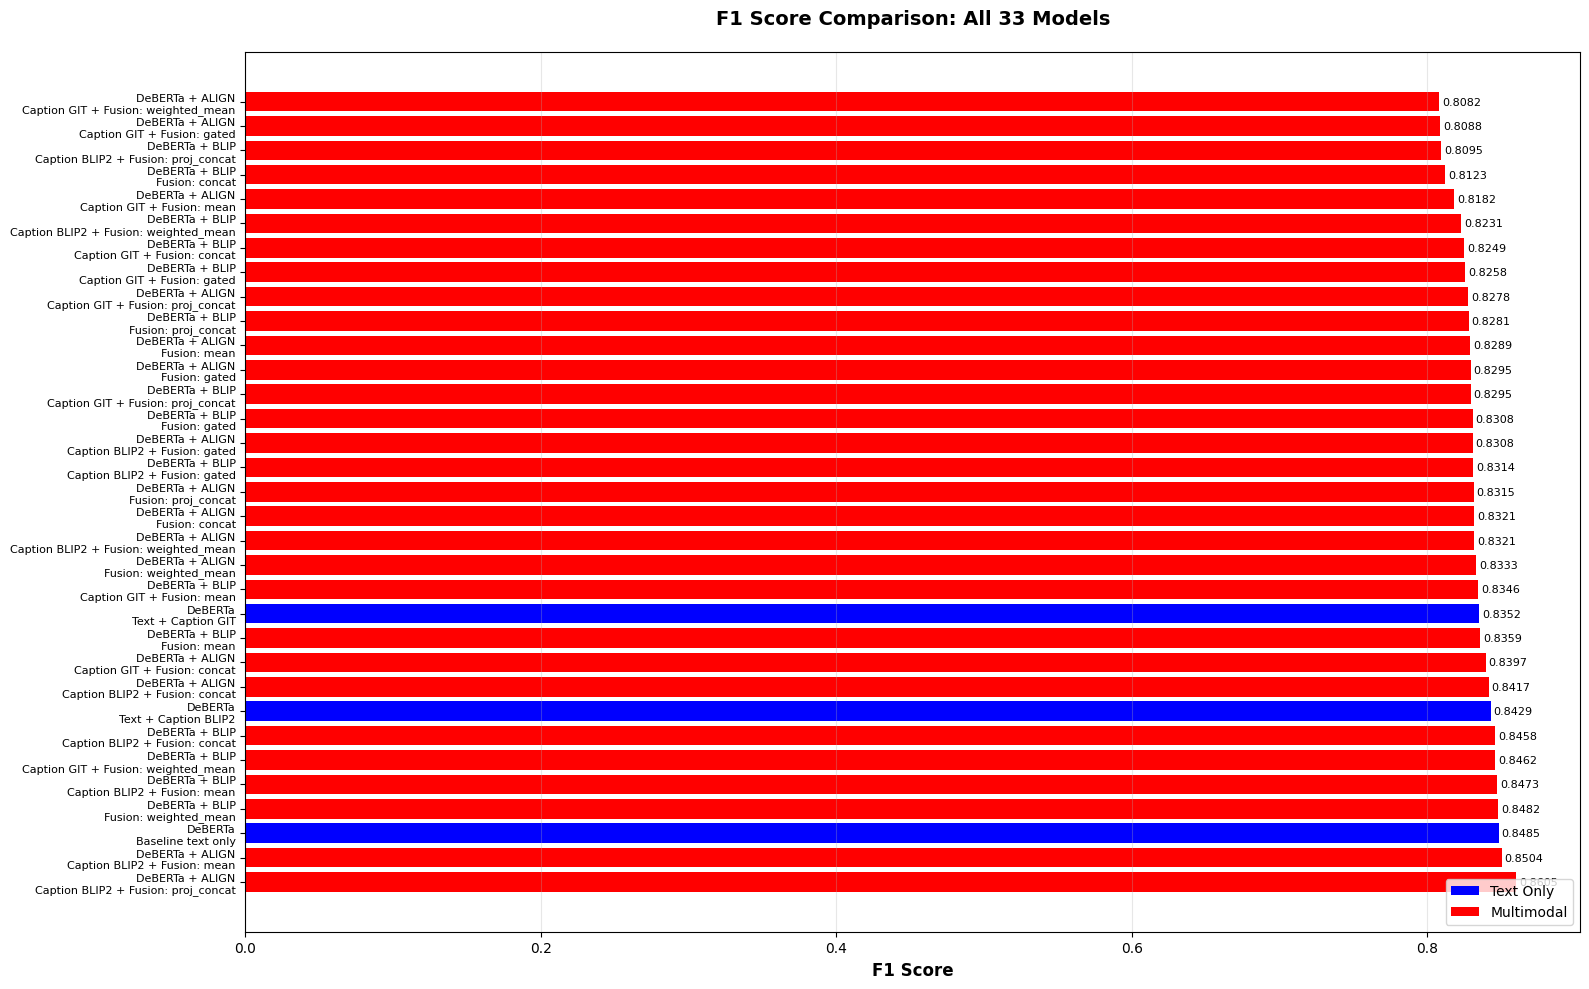

In [22]:
# Bar plot of performance of all 33 models
fig, ax = plt.subplots(figsize=(16, 10))
labels = [f"{row['Description']}\n{row['Comments']}" for _, row in df_results.iterrows()]
colors = ['blue' if tipo == 'Texto' else 'red' for tipo in df_results['Type']]
bars = ax.barh(range(len(df_results)), df_results['F1'], color=colors)
for i, (bar, f1) in enumerate(zip(bars, df_results['F1'])):
    ax.text(f1 + 0.002, i, f'{f1:.4f}', va='center', fontsize=8)

ax.set_yticks(range(len(df_results)))
ax.set_yticklabels(labels, fontsize=8)
ax.set_xlabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('F1 Score Comparison: All 33 Models', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', label='Text Only'),
    Patch(facecolor='red', label='Multimodal')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'f1_comparison_all_models.png'), dpi=300, bbox_inches='tight')
plt.show()

## Winner Model:

In [23]:
print(f"\nBEST OVERALL MODEL:")
best = df_results.iloc[0]
print(f"   Type: {best['Type']}")
print(f"   Description: {best['Description']}")
print(f"   Comments: {best['Comments']}")
print(f"   F1: {best['F1']:.4f}")
print(f"   Accuracy: {best['Accuracy']:.4f}")


BEST OVERALL MODEL:
   Type: Multimodal
   Description: DeBERTa + ALIGN
   Comments: Caption BLIP2 + Fusion: proj_concat
   F1: 0.8605
   Accuracy: 0.8800
